In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

2025-09-21 14:24:41.891698: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-21 14:24:41.891738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-21 14:24:41.892888: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-21 14:24:41.899888: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-21 14:24:42.728963: W tensorflow/compiler/tf2

In [2]:
# Set random seeds
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
## Loading the data
dataframe = pd.read_csv("Mobile-Price-Prediction-cleaned_data.csv")
dataframe.head()

,Ratings,RAM,ROM,Mobile_Size,Primary_Cam,Selfi_Cam,Battery_Power,Price
0,4.3,4.0,128.0,6.00,48,13.0,4000,24999
1,3.4,6.0,64.0,4.50,48,12.0,4000,15999
2,4.3,4.0,4.0,4.50,64,16.0,4000,15000
3,4.4,6.0,64.0,6.40,48,15.0,3800,18999
4,4.5,6.0,128.0,6.18,35,15.0,3800,18999


In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ratings        807 non-null    float64
 1   RAM            807 non-null    float64
 2   ROM            807 non-null    float64
 3   Mobile_Size    807 non-null    float64
 4   Primary_Cam    807 non-null    int64  
 5   Selfi_Cam      807 non-null    float64
 6   Battery_Power  807 non-null    int64  
 7   Price          807 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 50.6 KB


In [5]:
dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
Ratings,807.0,4.112639,0.367830,2.8,3.9,4.10,4.4,4.8
RAM,807.0,5.941760,2.056359,0.0,6.0,6.00,6.0,12.0
ROM,807.0,64.390335,53.868626,2.0,32.0,32.00,64.0,256.0
Mobile_Size,807.0,5.620660,3.957409,2.0,4.5,4.77,6.3,44.0
Primary_Cam,807.0,47.821561,11.155916,5.0,48.0,48.00,48.0,64.0
Selfi_Cam,807.0,8.868649,4.547254,0.0,8.0,8.00,12.0,23.0
Battery_Power,807.0,3278.859975,937.628801,1020.0,3000.0,3000.00,3800.0,6000.0
Price,807.0,14269.167286,23092.739983,479.0,984.0,1699.00,18994.5,153000.0


In [6]:
# Separating predictors from targets
X = dataframe.drop("Price", axis=1)
y = dataframe["Price"]

In [7]:
## Shape of X and y
X.shape, y.shape

((807, 7), (807,))

In [8]:
# Split into train, val and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((564, 7), (243, 7), (564,), (243,))

In [9]:
## Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# For efficiency, convert data to tensors or as a tf_.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(128)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(128)

2025-09-21 14:24:43.833769: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-21 14:24:43.879402: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [12]:
for batch in train_dataset:
    print(len(batch[0]))

128
128
128
128
52


In [13]:
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [14]:
input_shape = X_train.shape[1]
input_shape

7

In [15]:
# Define Model using the Sequential API
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu", input_shape=(input_shape, )),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1) # regression output
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 4)                 3

In [17]:
## Define Optimizer, Loss and Metrics
optimizer = tf.keras.optimizers.Adam(1e-3)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer

### Compile Model

In [18]:
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=["mse"]
)

### Fitting the model

In [19]:
EPOCHS = 1000

history = model.fit(train_dataset,
         validation_data=val_dataset,
         epochs=EPOCHS)

Epoch 1/1000
5/5 [==============================] - 1s 35ms/step - loss: 693162432.0000 - mse: 693162432.0000 - val_loss: 836125568.0000 - val_mse: 836125568.0000
Epoch 2/1000
5/5 [==============================] - 0s 4ms/step - loss: 693149696.0000 - mse: 693149696.0000 - val_loss: 836107584.0000 - val_mse: 836107584.0000
Epoch 3/1000
5/5 [==============================] - 0s 4ms/step - loss: 693131264.0000 - mse: 693131264.0000 - val_loss: 836082240.0000 - val_mse: 836082240.0000
Epoch 4/1000
5/5 [==============================] - 0s 4ms/step - loss: 693105024.0000 - mse: 693105024.0000 - val_loss: 836045184.0000 - val_mse: 836045184.0000
Epoch 5/1000
5/5 [==============================] - 0s 4ms/step - loss: 693066816.0000 - mse: 693066816.0000 - val_loss: 835991104.0000 - val_mse: 835991104.0000
Epoch 6/1000
5/5 [==============================] - 0s 4ms/step - loss: 693010816.0000 - mse: 693010816.0000 - val_loss: 835910656.0000 - val_mse: 835910656.0000
Epoch 7/1000
5/5 [=========

### Making Predictions

In [20]:
## Evaluation after training
y_pred = model.predict(X_test)

# Calculate MAE or MSE manually
mse = tf.keras.metrics.mean_squared_error(y_test, y_pred).numpy().mean()
mae = tf.keras.metrics.mean_absolute_error(y_test, y_pred).numpy().mean()

print("Test MSE:", mse)
print("Test MAE:", mae)

8/8 [==============================] - 0s 3ms/step
Test MSE: 1309113500.0
Test MAE: 21494.148


In [21]:
from sklearn.metrics import r2_score

score = r2_score(y_test, y_pred)
score

0.6217675215171727

In [22]:
0.5220667749392034

0.5220667749392034

In [23]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

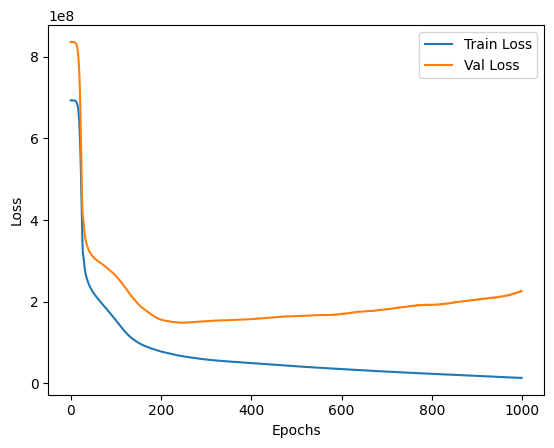

In [24]:
# Visualizing the History

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


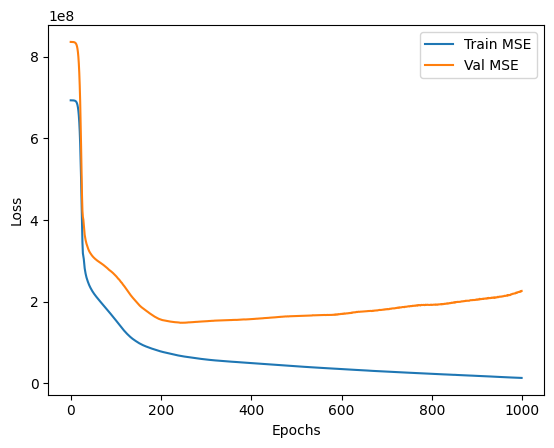

In [25]:
# Visualizing the History

plt.plot(history.history["mse"], label="Train MSE")
plt.plot(history.history["val_mse"], label="Val MSE")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
